In [1]:
import ROOT
import os
from xml_handle_new import *
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import matplotlib.colors as colors
import uproot

Welcome to JupyROOT 6.26/10


### Helpful Functions

In [3]:
def func(x,a,b,c):
    return a*x**2 + x*b + c

def combineCEandxavg(start, finish, path):



    run_list = []
    for filename in os.listdir(path):
        if filename.endswith(".root"):
            run_number = int(filename.split("_")[1].split(".")[0])
            run_list.append(run_number)

    run_list.sort()

    
    combine_detCE = []; combine_detxavg = []


    for i in run_list:
        if i >= start:
            if i <= finish:

                # print(i)
                df = ROOT.RDataFrame("SPSTree",f"{path}run_{i}.root")
                    
                final_CE = []
                              
            
                for j in range(5):

                    df_i = df.Filter(f"cebraE{j} != -1")
                    

                    # dettimecut = df_i.Define(f"cebra_RelTime_toScint_{j}", f"cebraTime{j} - scintLeftTime + {tshift[j]}")
                    # timecut = f"cebra_RelTime_toScint_{j} > {-twidth} && cebra_RelTime_toScint_{j} < {twidth}"
                    # dettimecut = dettimecut1.Filter(f"{timecut}")

                final_CE.append(pd.DataFrame(df_i.AsNumpy(columns = ['cebraE0_GM','cebraE1_GM','cebraE2_GM','cebraE3_GM','cebraE4_GM'])))
                    # finalCEarr.append(np.array(final_CE[j][f'cebraE{j}_GM']))

                    # final_xavg.append(pd.DataFrame(df_i.AsNumpy(columns = ['xavg'])))
                   
                
                # combine_detCE.append(np.concatenate(finalCEarr, axis = 0))
                # combine_detxavg.append(pd.concat(final_xavg, axis = 0))

    # totaldetCE = np.concatenate(combine_detCE, axis = 0)
    # totaldetxavg = pd.concat(combine_detxavg, axis = 0)
    
   
    return final_CE         

def general_xml(file):


    '''
    This function is the most up-to-date, general function that takes in the passed xml file and simply writes a calibrated & uncalibrated
    data file outputted at the same directory location where the code is called from.
    '''
    mytree = ET.parse(file)
    myroot = mytree.getroot()
 
    uncal_fit_list = []
    uncal_fit_err_list = []
    uncal_width_list = []
    uncal_width_err_list = []
    uncal_volume_list = []
    uncal_volume_err_list = []

    cal_fit_list = []
    cal_fit_err_list = []
    cal_width_list = []
    cal_width_err_list = []
    cal_volume_list = []
    cal_volume_err_list = []

    for fit in myroot:
        for i in fit:
            if i.tag == 'peak':
                for child in i.iter():
                    if child.tag == 'uncal':
                        for j in child.iter():
                            if j.tag == 'pos':
                                for newchild in j.iter():
                                    if newchild.tag == 'value':
                                        fit_value = newchild.text
                                        uncal_fit_list.append(float(fit_value))
                                    elif newchild.tag == 'error':
                                        fit_err = newchild.text
                                        uncal_fit_err_list.append(float(fit_err))
                            elif j.tag == 'vol':
                                for newchild in j.iter():
                                    if newchild.tag == 'value':
                                        vol_value = newchild.text
                                        uncal_volume_list.append(float(vol_value))
                                    elif newchild.tag == 'error':
                                        vol_err = newchild.text
                                        uncal_volume_err_list.append(float(vol_err))
                            elif j.tag == 'width':
                                for newchild in j.iter():
                                    if newchild.tag == 'value':
                                        width_value = newchild.text
                                        uncal_width_list.append(float(width_value))
                                    elif newchild.tag == 'error':
                                        width_err = newchild.text
                                        uncal_width_err_list.append(float(width_err))

                    #gets the calibrated data information                
                    if child.tag == 'cal':
                        for j in child.iter():
                            if j.tag == 'pos':
                                for newchild in j.iter():
                                    if newchild.tag == 'value':
                                        fit_value = newchild.text
                                        cal_fit_list.append(float(fit_value))
                                    elif newchild.tag == 'error':
                                        fit_err = newchild.text
                                        cal_fit_err_list.append(float(fit_err))
                            elif j.tag == 'vol':
                                for newchild in j.iter():
                                    if newchild.tag == 'value':
                                        vol_value = newchild.text
                                        cal_volume_list.append(float(vol_value))
                                    elif newchild.tag == 'error':
                                        vol_err = newchild.text
                                        cal_volume_err_list.append(float(vol_err))
                            elif j.tag == 'width':
                                for newchild in j.iter():
                                    if newchild.tag == 'value':
                                        width_value = newchild.text
                                        cal_width_list.append(float(width_value))
                                    elif newchild.tag == 'error':
                                        width_err = newchild.text
                                        cal_width_err_list.append(float(width_err))
    
    # uncalibrated data handling
    uncal_list = []
    for val in zip(uncal_fit_list, uncal_fit_err_list, uncal_width_list, uncal_width_err_list, uncal_volume_list, uncal_volume_err_list):  #interleaves lists together
        uncal_list.append(val)
    sorted_uncal_list = sorted(uncal_list, reverse=True)

    # calibrated data handling

    cal_list = []
    for val in zip(cal_fit_list, cal_fit_err_list, cal_width_list, cal_width_err_list, cal_volume_list, cal_volume_err_list):  #interleaves lists together
        cal_list.append(val)
    sorted_cal_list = sorted(cal_list, reverse=True)

    return cal_list

def output(detnum, fit_params):

    output_file = f"fit_paramsdet{detnum}.txt"
    # Open the file in write mode
    with open(output_file, 'w') as file:
        # Iterate over the fit parameters
        for i, parameters in enumerate(fit_params):
            # Write the "s s i" command
            file.write(f"s s {i}\n")

            # Extract fit parameters for the current run
            x, y, z = parameters

            # Write the command for calibration position
            file.write("calibration position set {:.10f} {:.10f} {:.10f}\n".format(z, y, x))
    return 

def fitruns(detlist, standardrun, detnum, out): 
    # A function that plots peak positions against a standard and fits a line.
    # Those parameters can then be used to calibrate spectra to the standard.
    standard = np.array(standardrun)
    stpeaks = standard[:,0]

    p0 = [(1,1,0)]
    fit_params = np.zeros((len(detlist),3))
    dfit_params = np.zeros((len(detlist),3))
    pcal = np.zeros((5,len(detlist[0]),8)) ; dpcal = np.zeros((len(detlist[0]),8))
    for i in range(len(detlist)):

        popt, pcov = opt.curve_fit(func, np.array(detlist[i])[:,0], stpeaks, p0 = p0)
        perr= np.sqrt(np.diag(pcov))
        #data_fitted = func(np.array(det0[i])[:,0], *popt)
        fit_params[i,:] = popt
        dfit_params[i,:] = perr

        for j in range(8):

            pcal[k,i,j] = func(np.array(detlist[i])[:,0], *fit_params[i])[j] # calibrating peak positions according to parameters found in above loop

    if out == True:
        output(detnum,fit_params)
    return fit_params, dfit_params

### Getting Fits and Calibrating them

In [4]:
# Taking, sorting, and appending the fit positions
det0dir = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/fits/det_0'
det1dir = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/fits/det_1'
det2dir = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/fits/det_2'
det3dir = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/fits/det_3'
det4dir = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/fits/det_4'

det_0_xml = sorted(glob(f'{det0dir}/*.fit'))
det_1_xml = sorted(glob(f'{det1dir}/*.fit'))
det_2_xml = sorted(glob(f'{det2dir}/*.fit'))
det_3_xml = sorted(glob(f'{det3dir}/*.fit'))
det_4_xml = sorted(glob(f'{det4dir}/*.fit'))

# extracting from xml files so I can work with them in python
det0 = [];det1 = [];det2 = [];det3 = [];det4 = []
for i in range(len(det_0_xml)):
    det0.append(general_xml(det_0_xml[i]))
    det1.append(general_xml(det_1_xml[i]))
    det2.append(general_xml(det_2_xml[i]))
    det3.append(general_xml(det_3_xml[i]))
    det4.append(general_xml(det_4_xml[i]))

In [5]:
standard = np.array(det0[29]) # defining standard run (run 127)

stpeaks = standard[:,0]

print(stpeaks)

[ 279.91974515  707.71355231 1116.85609396 1225.51120859  568.91851453
  890.1594986   992.2627117  1626.892423  ]


In [6]:
standard = np.array(det0[29]) # defining standard run (run 127)

stpeaks = standard[:,0]


detlist = [det0,det1,det2,det3,det4]
runs = len(det0)
p0 = [(0,1,0)]
fit_params = np.zeros((runs,3))
dfit_params = np.zeros((runs,3))
diff = np.zeros((5,runs,8)); Ddiff = np.zeros((5,runs,8))
peaks = np.zeros((len(det0),8)); dpeaks = np.zeros((len(det0),8))
pcal = np.zeros((5,len(det0),8)) ; dpcal = np.zeros((len(det0),8))

for k in range(5):
    det = detlist[k] # getting list of fit positions for specific detector

    for i in range(len(det)):

        peaks[i] = np.array(det[i])[:,0] # getting peak position
        dpeaks[i] = np.array(det[i])[:,1] # uncertainty in peak position

        popt, pcov = opt.curve_fit(func, peaks[i], stpeaks, p0 = p0) # making fit with standard peaks
        perr= np.sqrt(np.diag(pcov)) # giving parameter uncertainties

        #data_fitted = func(np.array(det0[i])[:,0], *popt)
        fit_params[i,:] = popt # saving parameters 
        dfit_params[i,:] = perr # saving parameter uncertainties

        for j in range(8):

            pcal[k,i,j] = func(peaks[i], *fit_params[i])[j] # calibrating peak positions according to parameters found in above loop
            
            diff[k,i,j] = stpeaks[j] - pcal[k,i,j]

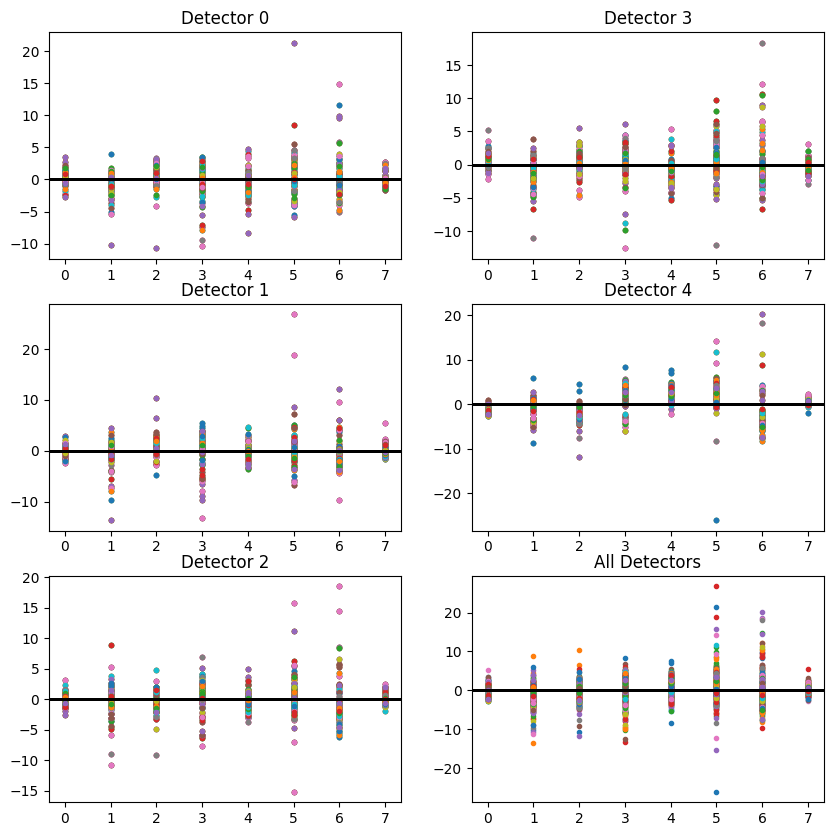

In [7]:
x = np.linspace(0,7, num = 8)

fig, axs = plt.subplots(3,2, figsize = (10,10))
for j in range(5):
    for i in range(len(diff[0])):
        axs[0,0].scatter(x, diff[0,i,:], marker = '.')
        axs[0,0].set_title('Detector 0')
        axs[0,0].axhline(y=0, color = 'black', linewidth = 0.8)

        axs[1,0].scatter(x, diff[1,i,:], marker = '.')
        axs[1,0].set_title('Detector 1')
        axs[1,0].axhline(y=0, color = 'black', linewidth = 0.8)

        axs[2,0].scatter(x, diff[2,i,:], marker = '.')
        axs[2,0].set_title('Detector 2')
        axs[2,0].axhline(y=0, color = 'black', linewidth = 0.8)

        axs[0,1].scatter(x, diff[3,i,:], marker = '.')
        axs[0,1].set_title('Detector 3')
        axs[0,1].axhline(y=0, color = 'black', linewidth = 0.8)

        axs[1,1].scatter(x, diff[4,i,:], marker = '.')
        axs[1,1].set_title('Detector 4')
        axs[1,1].axhline(y=0, color = 'black', linewidth = 0.8)
        
        axs[2,1].scatter(x, diff[j,i,:], marker = '.')
        axs[2,1].set_title('All Detectors')
        axs[2,1].axhline(y=0, color = 'black', linewidth = 0.8)

In [8]:
# using a function to do procedure above for each detector
det0fits = fitruns(det0,det0[29],0,True)
det1fits = fitruns(det1,det0[29],1,True)
det2fits = fitruns(det2,det0[29],2,True)
det3fits = fitruns(det3,det0[29],3,True)
det4fits = fitruns(det4,det0[29],4,True)

detfits = []
detfits.append(det0fits)
detfits.append(det1fits)
detfits.append(det2fits)
detfits.append(det3fits)
detfits.append(det4fits)

IndexError: index 8 is out of bounds for axis 1 with size 8

In [162]:
np.shape(detfits[0])
# detfits[detector][fit_params = 0; dfit = 1][run#,column#]
print(detfits[0][0][29,0])
# print(pcal[0,29,1])

5.579101632864474e-12


### Getting CeBrA Spectra for each detector

In [9]:
def GetCE(path, det):

    run_list = []
    for filename in os.listdir(path):
        if filename.endswith(".root"):
            run_number = int(filename.split("_")[1].split(".")[0])
            run_list.append(run_number)

    run_list.sort() # make sure to cross check what run_list number corresponds to what run

    j = det
    final_CE = []
    for i in run_list:

        # print(i)
        df = ROOT.RDataFrame("SPSTree",f"{path}run_{i}.root")                           
        
        df_i = df.Filter(f"cebraE{j} != -1")

        final_CE.append(pd.DataFrame(df_i.AsNumpy(columns = [f'cebraE{j}_GM'])))
        # finalCEarr.append(np.array(final_CE[j][f'cebraE{j}_GM']))

        # combine_detCE.append(np.concatenate(finalCEarr, axis = 0))
            
    # totaldetCE = np.concatenate(combine_detCE, axis = 0)

    return final_CE

In [10]:
# path = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/'
# run_list = []
# for filename in os.listdir(path):
#     if filename.endswith(".root"):
#         run_number = int(filename.split("_")[1].split(".")[0])
#         run_list.append(run_number)

# run_list.sort()
# print(run_list[94])

In [11]:
path = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/'
det0spec =  GetCE(path, 0)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


In [250]:
det1spec =  GetCE(path, 1)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


In [252]:
det2spec =  GetCE(path, 2)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


In [254]:
det3spec =  GetCE(path, 3)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


In [257]:
det4spec =  GetCE(path, 4)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


Text(0, 0.5, 'Counts')

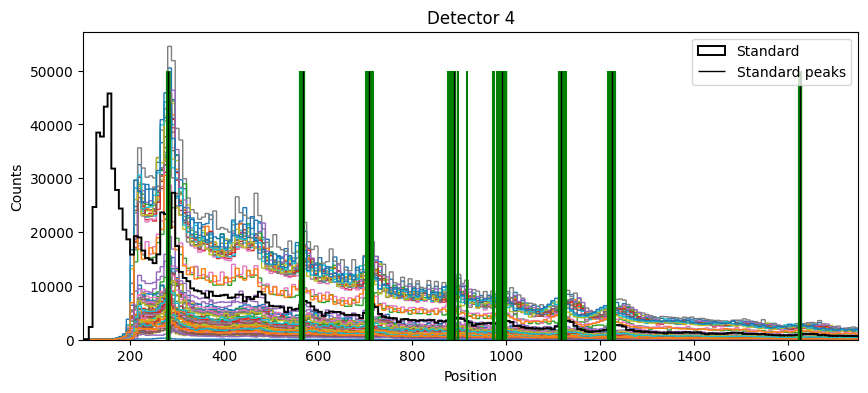

In [259]:
plt.figure(figsize = (10,4))
for i in range(len(det0spec)):
    # plt.hist(det0spec[i]['cebraE0_GM'], bins = 512, range = [0,4096],histtype= 'step')
    # plt.hist(det1spec[i]['cebraE1_GM'], bins = 512, range = [0,4096],histtype= 'step')
    # plt.hist(det2spec[i]['cebraE2_GM'], bins = 512, range = [0,4096],histtype= 'step')
    # plt.hist(det3spec[i]['cebraE3_GM'], bins = 512, range = [0,4096],histtype= 'step')
    plt.hist(det4spec[i]['cebraE4_GM'], bins = 512, range = [0,4096],histtype= 'step')
plt.hist(det0spec[94]['cebraE0_GM'], bins = 512, range = [0,4096], label = 'Standard', color = 'black', linewidth = 1.4, histtype= 'step')
# plt.hist(det0spec[94]['cebraE0_GM'], bins = 512, range = [0,4096], label = 'Standard', color = 'red', linewidth = 1.4, histtype= 'step')
# plt.title('Detector 0 all runs')

k=4
for i in range(len(pcal[k])):
    for j in range(len(pcal[k,i,:])):
        plt.vlines(pcal[k,i,j], ymin = 0, ymax = 50000, color = 'green')

plt.vlines(stpeaks, color = 'black', linewidth = 1, ymin = 0, ymax = 50000, label = 'Standard peaks')
plt.xlim(100,1750)
plt.legend(loc = 'best')
plt.title(f'Detector {k}')
plt.xlabel('Position')
plt.ylabel('Counts')


### CeBra Energy vs. CeBrA Time Plots

These plots will help show if there were any energy shifts during individual runs. If there were, then it could be the cause of the shifting of the horizontal band in the particle-$\gamma$ matrix.

In [12]:
def GetCT(path, det):

    run_list = []
    for filename in os.listdir(path):
        if filename.endswith(".root"):
            run_number = int(filename.split("_")[1].split(".")[0])
            run_list.append(run_number)

    run_list.sort() # make sure to cross check what run_list number corresponds to what run

    j = det
    final_CT = []
    for i in run_list:

        # print(i)
        df = ROOT.RDataFrame("SPSTree",f"{path}run_{i}.root")                           
        
        df_i = df.Filter(f"cebraE{j} != -1")

        final_CT.append(pd.DataFrame(df_i.AsNumpy(columns = [f"cebraTime{j}"])))
        # finalCEarr.append(np.array(final_CE[j][f'cebraE{j}_GM']))

        # combine_detCE.append(np.concatenate(finalCEarr, axis = 0))
            
    # totaldetCE = np.concatenate(combine_detCE, axis = 0)

    return final_CT

def GetCE(path, det):

    run_list = []
    for filename in os.listdir(path):
        if filename.endswith(".root"):
            run_number = int(filename.split("_")[1].split(".")[0])
            run_list.append(run_number)

    run_list.sort() # make sure to cross check what run_list number corresponds to what run

    j = det
    final_CE = []
    for i in run_list:

        # print(i)
        df = ROOT.RDataFrame("SPSTree",f"{path}run_{i}.root")                           
        
        df_i = df.Filter(f"cebraE{j} != -1")

        final_CE.append(pd.DataFrame(df_i.AsNumpy(columns = [f'cebraE{j}'])))
        # finalCEarr.append(np.array(final_CE[j][f'cebraE{j}_GM']))

        # combine_detCE.append(np.concatenate(finalCEarr, axis = 0))
            
    # totaldetCE = np.concatenate(combine_detCE, axis = 0)

    return final_CE

In [13]:
path = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/'
det0time =  GetCT(path, 0)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


In [14]:
det0E = GetCE(path,0)

Warning in <TFile::Init>: file /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GainMatched/run_11.root, recovered key TTree:SPSTree at address 58015005
Warning in <TFile::Init>: successfully recovered 1 keys


In [306]:
x = np.linspace(0, len(det0time[0]['cebraTime0']), len(det0time[0]['cebraTime0']))
print(np.shape(x))
print(np.shape(det0time[0]['cebraTime0']))

(11032,)
(11032,)


Text(0.5, 1.0, 'Energy vs. Time')

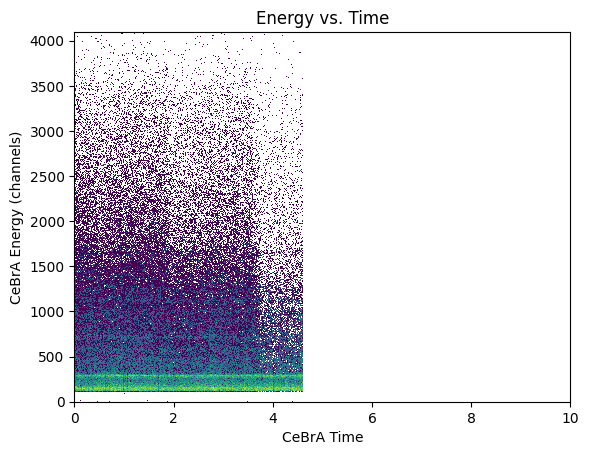

In [16]:
xmax = det0time[0]['cebraTime0'][len(det0time[0]['cebraTime0'])-1]*10**-12
plt.figure()
for i in range(5):
    plt.hist2d(det0time[i]['cebraTime0']*10**-12, det0E[i]['cebraE0'], bins = [1000,512], cmap = 'viridis', norm = colors.LogNorm(),range = [[0,10],[0,4096]])

plt.xlabel('CeBrA Time')
plt.ylabel('CeBrA Energy (channels)')
plt.title('Energy vs. Time')